# Pneumonia Detection Project

We have some Image classification of X_ray images

Here two approaches are used one using CNN and VGG16.

VGG16 is existing model of convolution neural networks.

We used it for transfer learning.

## Mounting the drive

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [5]:
!unzip '/content/gdrive/MyDrive/X_ray_PNUEMONIA_Detection.zip'

Archive:  /content/gdrive/MyDrive/X_ray_PNUEMONIA_Detection.zip
  inflating: X_ray_PNUEMONIA_Detection/Pneumonia_detection_using_Transfer_Learning.ipynb  
  inflating: X_ray_PNUEMONIA_Detection/test_small.zip  
  inflating: X_ray_PNUEMONIA_Detection/train_small.zip  


In [6]:
!unzip '/content/X_ray_PNUEMONIA_Detection/train_small.zip'

Archive:  /content/X_ray_PNUEMONIA_Detection/train_small.zip
   creating: train_small/
   creating: train_small/NORMAL/
  inflating: train_small/NORMAL/IM-0115-0001.jpeg  
  inflating: train_small/NORMAL/IM-0117-0001.jpeg  
  inflating: train_small/NORMAL/IM-0119-0001.jpeg  
  inflating: train_small/NORMAL/IM-0122-0001.jpeg  
  inflating: train_small/NORMAL/IM-0125-0001.jpeg  
  inflating: train_small/NORMAL/IM-0127-0001.jpeg  
  inflating: train_small/NORMAL/IM-0128-0001.jpeg  
  inflating: train_small/NORMAL/IM-0129-0001.jpeg  
  inflating: train_small/NORMAL/IM-0131-0001.jpeg  
  inflating: train_small/NORMAL/IM-0133-0001.jpeg  
  inflating: train_small/NORMAL/IM-0135-0001.jpeg  
  inflating: train_small/NORMAL/IM-0137-0001.jpeg  
  inflating: train_small/NORMAL/IM-0140-0001.jpeg  
  inflating: train_small/NORMAL/IM-0141-0001.jpeg  
  inflating: train_small/NORMAL/IM-0143-0001.jpeg  
  inflating: train_small/NORMAL/IM-0145-0001.jpeg  
  inflating: train_small/NORMAL/IM-0147-0001.jpe

In [7]:
!unzip '/content/X_ray_PNUEMONIA_Detection/test_small.zip'

Archive:  /content/X_ray_PNUEMONIA_Detection/test_small.zip
   creating: test_small/
   creating: test_small/NORMAL/
  inflating: test_small/NORMAL/IM-0001-0001.jpeg  
  inflating: test_small/NORMAL/IM-0003-0001.jpeg  
  inflating: test_small/NORMAL/IM-0005-0001.jpeg  
  inflating: test_small/NORMAL/IM-0006-0001.jpeg  
  inflating: test_small/NORMAL/IM-0007-0001.jpeg  
  inflating: test_small/NORMAL/IM-0009-0001.jpeg  
  inflating: test_small/NORMAL/IM-0010-0001.jpeg  
  inflating: test_small/NORMAL/IM-0011-0001-0001.jpeg  
  inflating: test_small/NORMAL/IM-0011-0001-0002.jpeg  
  inflating: test_small/NORMAL/IM-0011-0001.jpeg  
  inflating: test_small/NORMAL/IM-0013-0001.jpeg  
  inflating: test_small/NORMAL/IM-0015-0001.jpeg  
  inflating: test_small/NORMAL/IM-0016-0001.jpeg  
  inflating: test_small/NORMAL/IM-0017-0001.jpeg  
  inflating: test_small/NORMAL/IM-0019-0001.jpeg  
  inflating: test_small/NORMAL/IM-0021-0001.jpeg  
  inflating: test_small/NORMAL/IM-0022-0001.jpeg  
  infl

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
import cv2
import numpy as np
import os
import pandas as pd

In [9]:
# VGG model requires 224*224 input so we need to re-size all images
IMAGE_SIZE = [224, 224]

In [10]:
train_path = 'train_small'
valid_path = 'test_small'

# Loading Data by Generator

Generator can create random variations in the given images for generalization of training

In [13]:
# example of progressively loading images from file
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# create generator
# generator applied random preprocessing to make the model --> robust
datagen = ImageDataGenerator(rescale = 1./255,
                             shear_range = 0.2, # every image will be randomly distorted 0-0.2
                             zoom_range = 0.2, # every image will be randomly zoomed 0-0.2
                             horizontal_flip = True, #
                             vertical_flip=True,
                             rotation_range=30) #every image will be randomly ratated 0-30 degree
# prepare an iterators for each dataset
train_it = datagen.flow_from_directory( './train_small/',
                                       class_mode='categorical',
                                       classes=['NORMAL', 'PNEUMONIA'],
                                       target_size=(224, 224),
                                       batch_size=2,
                                       seed=7)
val_it = datagen.flow_from_directory('./test_small/',
                                       class_mode='categorical',
                                       classes=['NORMAL', 'PNEUMONIA'],
                                       target_size=(224, 224),
                                       batch_size=2,
                                       seed=7)
test_it = datagen.flow_from_directory('./test_small/',
                                       class_mode='categorical',
                                       classes=['NORMAL', 'PNEUMONIA'],
                                       target_size=(224, 224),
                                       batch_size=2,
                                       seed=7)
# confirm the iterator works
batchX, batchy = next(train_it)
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

Found 101 images belonging to 2 classes.
Found 46 images belonging to 2 classes.
Found 46 images belonging to 2 classes.
Batch shape=(2, 224, 224, 3), min=0.000, max=0.999


# Create Simple CNN model

In [14]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import Sequential

In [15]:
model = Sequential()
model.add(Conv2D(32, (5,5),padding='valid',activation='relu',
                 input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(4,4)))
# REPEAT CONV AND POOLING layer 3 TIMES
model.add(Conv2D(64, (5,5),padding='valid',activation='relu'))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Conv2D(128, (5,5),padding='valid',activation='relu'))
# model.add(Conv2D(256, (5,5),padding='valid',activation='relu'))
# model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Flatten())
# any no of dense layers
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(2,activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 220, 220, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 55, 55, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 51, 51, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,315,714 (5.02 MB)

 Trainable params: 1,315,714 (5.02 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
from tensorflow.keras.losses import CategoricalCrossentropy
model.compile(
  optimizer='adam',
  loss=CategoricalCrossentropy(),
  metrics=['accuracy'])

In [18]:
history = model.fit(
  train_it,
  validation_data=val_it,
  epochs=5)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 0.8083 - loss: 0.6953 - val_accuracy: 0.5000 - val_loss: 0.7580
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.7890 - loss: 0.8034 - val_accuracy: 0.5000 - val_loss: 0.7808
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.7071 - loss: 0.5897 - val_accuracy: 0.5000 - val_loss: 1.0713
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.7840 - loss: 0.4875 - val_accuracy: 0.5000 - val_loss: 0.7417
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.6994 - loss: 0.7435 - val_accuracy: 0.5000 - val_loss: 0.6970


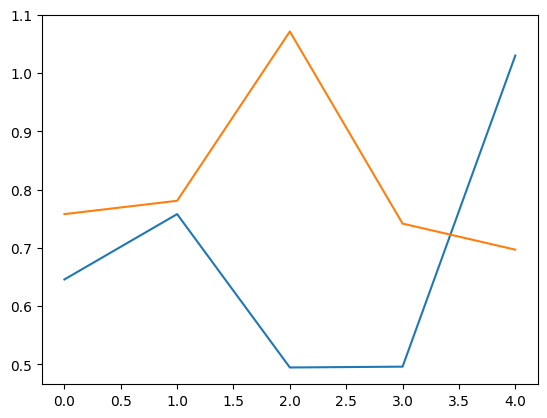

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# VGG16 Model (Transfer Learning)

#### add preprocessing layer to the front of VGG
#### [3] add 3 Channles ie RGB
#### We are importing weights from imagenet use it as it is
#### include_top means we last layer in VGG16 Model we dont want this
#### Because with help of VGG we are tyring to solve own problem

In [20]:
IMAGE_SIZE = [224, 224]

In [21]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [22]:
for layer in vgg.layers:
  layer.trainable = False

# Adding Our Layers at End of VGG16

In [23]:
output_classes = 2

In [24]:
# our layers - we can add more if you want
x = Flatten()(vgg.output)
x = Dense(1000, activation='relu')(x)
# x = Dense(500, activation='relu')(x)
prediction = Dense(output_classes, activation='softmax')(x)

In [25]:
# creating a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [26]:
# viewing the structure of the model
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1000)                │      25,089,000 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 39,805,690 (151.85 MB)

 Trainable params: 25,091,002 (95.71 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [27]:
# telling the model what cost and optimization method to use
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [28]:
history_vgg= model.fit(
  train_it,
  validation_data=val_it,
  epochs=5
)

Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 0.8123 - loss: 2.2406 - val_accuracy: 0.6087 - val_loss: 3.4171
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - accuracy: 0.9206 - loss: 0.4627 - val_accuracy: 0.5870 - val_loss: 2.1842
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.9045 - loss: 0.7231 - val_accuracy: 0.7826 - val_loss: 1.4273
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.9596 - loss: 0.2740 - val_accuracy: 0.5870 - val_loss: 5.1233
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.8050 - loss: 1.0956 - val_accuracy: 0.8043 - val_loss: 1.2163


In [29]:
history_vgg.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

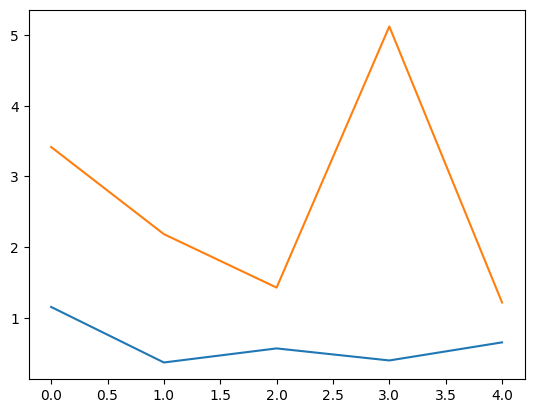

In [30]:
import matplotlib.pyplot as plt
plt.plot(history_vgg.history['loss'])
plt.plot(history_vgg.history['val_loss'])

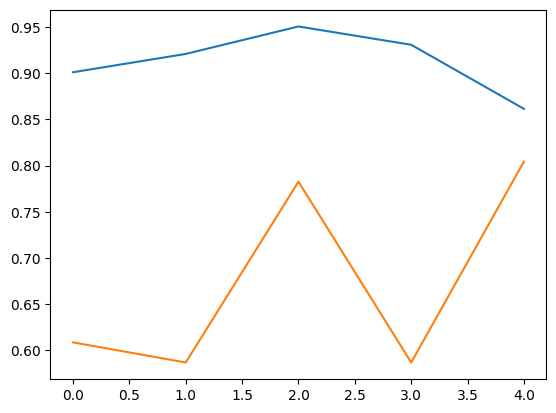

In [31]:
plt.plot(history_vgg.history['accuracy'])
plt.plot(history_vgg.history['val_accuracy'])

# Resnet50 Model

In [32]:
from tensorflow.keras.applications import ResNet50

In [33]:
resnet = ResNet50(include_top=True,weights="imagenet",input_shape=(224,224,3),classes=1000)

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [34]:
resnet.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [35]:
for layer in resnet.layers[:-2]:
  layer.trainable = False

# Adding Our Layers at End of Resnet50

In [36]:
output_classes = 2

In [41]:
# our layers - we can add more if we want
x = Flatten()(resnet.layers[-2].output)
# x = Dense(5000, activation='relu')(x)
x = Dense(500, activation='relu')(x)
prediction = Dense(output_classes, activation='softmax')(x)

In [42]:
# creating a model object
model = Model(inputs=resnet.input, outputs=prediction)

In [43]:
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,613,214 (93.89 MB)

 Trainable params: 1,025,502 (3.91 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [44]:
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [45]:
history_resnet= model.fit(
  train_it,
  validation_data=val_it,
  epochs=5
  )

Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 22s 225ms/step - accuracy: 0.6601 - loss: 0.7748 - val_accuracy: 0.5000 - val_loss: 0.9433
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - accuracy: 0.7771 - loss: 0.5707 - val_accuracy: 0.5000 - val_loss: 0.7972
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.7739 - loss: 0.5089 - val_accuracy: 0.5000 - val_loss: 0.7270
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.7928 - loss: 0.4804 - val_accuracy: 0.5000 - val_loss: 0.8106
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.7372 - loss: 0.5712 - val_accuracy: 0.5000 - val_loss: 0.7370


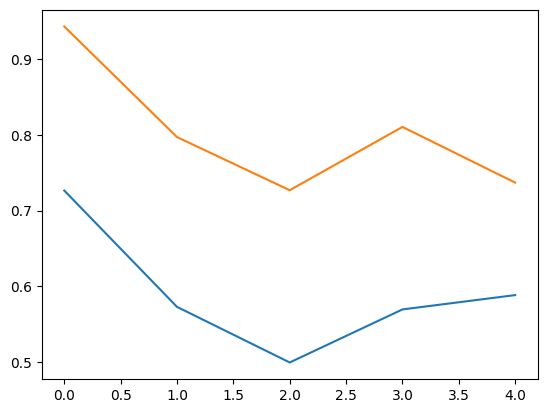

In [46]:
plt.plot(history_resnet.history['loss'])
plt.plot(history_resnet.history['val_loss'])

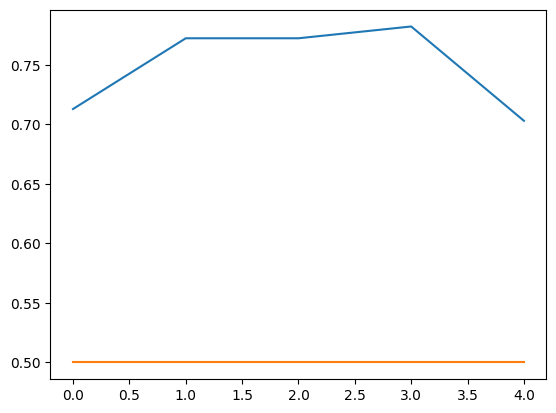

In [47]:
plt.plot(history_resnet.history['accuracy'])
plt.plot(history_resnet.history['val_accuracy'])